In [1]:
import sys, os

sys.path.append(os.getcwd())
from lmf import *
from pymatgen.io.cif import CifParser, CifWriter
from pymatgen import Structure, Lattice
from matplotlib import pyplot as plt
from pymatgen.io.ase import AseAtomsAdaptor as p2ase
import ase
from IPython.core.display import Image
from contextlib import contextmanager
from pathlib import Path
import time
import json
import os
plt.rcParams.update({"font.size": 9})
# ----for logging into file------------
# import subprocess, os, sys
# tee = subprocess.Popen(["tee", "log.txt"], stdin=subprocess.PIPE)
# os.dup2(tee.stdin.fileno(), sys.stdout.fileno())
# os.dup2(tee.stdin.fileno(), sys.stderr.fileno())


# Calculation code

In [2]:
def get_structure(d=10, a=0):
    species = []
    coords = []
    for i in structure:
        if i.species_string == "Li":
            species.append(i.species)
            coords.append(i.coords + [0, 0, +0.5 * d - a])
        else:
            species.append(i.species)
            coords.append(i.coords)
    a = structure.lattice.matrix.copy()
    a[2][2] = a[2][2] + d
    struc = Structure(Lattice(a), species, coords, coords_are_cartesian=True)
    #     CifWriter(struc).write_file(fname+'licoo2_'+str(struc.lattice.c)[:4]+'.cif')
    #     CifWriter(struc).write_file(fname+'licoo2_big.cif')
    #     os.system("open "+fname+'licoo2_big.cif')
    return struc


@contextmanager
def cd(newdir):
    prevdir = os.getcwd()
    os.chdir(os.path.expanduser(newdir))
    try:
        yield
    finally:
        os.chdir(prevdir)


def append_record(record, fname):
    with open(fname, "a") as f:
        json.dump(record, f)
        f.write(os.linesep)


In [ ]:
# ----------------variables--------
num_processors = 12
nc = 1
nd = 10
c_axis = np.linspace(0.5, 1.2, nc)
d_move = np.linspace(0, 0.18, nd)
structure_data_fname = "structures_done.txt"
# --------load previous calculation and see if its already done.------------------
try:
    with open(structure_data_fname) as f:
        my_list = [json.loads(line) for line in f]
    done_structures = [Structure.from_dict(i) for i in my_list]
except:
    done_structures = []
    print("no old calculation found")

# -----------load Main structure---------------------------------------------------
parser = CifParser("structures_files/licoo2.cif")
structure = parser.get_structures()[0]

# -------------Main calculation---------------------------------------------------
for c in c_axis:
    for d in d_move:
        struc = get_structure(c, d)
        dictonary = struc.as_dict()
        atoms = p2ase().get_atoms(struc)
        if struc not in done_structures:
            start_time = time.time()
            fname = "./" + str(c) + "_caxis/" + str(d)
            Path(fname).mkdir(parents=True, exist_ok=True)
            print("running c={} and d= {}".format(c, d))
            with cd(fname):
                calculator = lmf(nkabc=[4, 4, 4], ctrl="temp", p=num_processors)
                pot_energy = calculator.get_potential_energy(atoms)
                dictonary["energy"] = pot_energy
                energies.append(pot_energy)
                # lmf().clean()

            # ---time calculations
            elapsed_time = time.time() - start_time
            total_time = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))
            program_time_ellapsed_unformated = time.time() - program_start_time
            program_time_ellapsed = time.strftime(
                "%H:%M:%S", time.gmtime(program_time_ellapsed_unformated)
            )

            # ---load the structure and energy to completed dictonray
            append_record(dictonary, structure_data_fname)
            print(
                "completed in {} total time {}\n =================\n".format(
                    total_time, program_time_ellapsed
                )
            )
        else:
            print("!!!!!!!!!!!!!!!!!")
            print("calculation for c={} and d= {} alread done".format(c, d))
            print("!!!!!!!!!!!!!!!!!\n")


# Plotting

In [ ]:
# structure_data_fname="structures_done.txt"
# with open(structure_data_fname) as f:
#     my_list = [json.loads(line) for line in f]
# done_structures=[Structure.from_dict(i) for i in my_list]

# class my_structures:
#     def __init__(self, structure,energy):
#         self.structure = structure
#         self.energy=energy
#         self.c=structure.lattice.c
#         self.distance=np.linalg.norm(structure[0].coords-structure[1].coords)
# done_structures=[]
# for i in my_list:
#     struc=Structure.from_dict(i)
#     energy=i["energy"]
#     done_structures.append(my_structures(struc,energy))

# distances=np.array([i.distance for i in done_structures])
# energy=np.array([i.energy for i in done_structures])
# c=np.array([i.c for i in done_structures])
# import pandas as pd
# data={"c":c,
#       "distance":distances,
#     "energy":energy}
# df = pd.DataFrame(data) 
# #df.head()

In [2]:
# ------------------curve fit phase
from scipy.optimize import curve_fit


def phase(x, a, b):
    return a * x ** 2 + b * x ** 4


def straight(x, a0, lc):
    return a0 * (x - lc)  # +lc2 * (x**2)


# --------------add second axis in plots
def addsecond(ax, tickinfo):
    ax2 = ax.twiny()

    def tick_function(X):
        V = X
        return ["%.3f" % z for z in V]

    # Move twinned axis ticks and label from top to bottom
    ax2.xaxis.set_ticks_position("bottom")
    ax2.xaxis.set_label_position("bottom")

    # Offset the twin axis below the host
    ax2.spines["bottom"].set_position(("axes", -0.35))

    # Turn on the frame for the twin axis, but then hide all
    # but the bottom spine
    ax2.set_frame_on(True)
    ax2.patch.set_visible(False)
    for sp in ax2.spines.values():
        sp.set_visible(False)
    ax2.spines["bottom"].set_visible(True)

    ax2.set_xticks(np.linspace(0, 1, len(tickinfo)))
    ax2.set_xticklabels(tickinfo)
    ax2.set_xlabel(r"% lattice expansion")


# --------------class to read saced data
structure_data_fname = "licoo2/structures_done.txt"
with open(structure_data_fname) as f:
    my_list = [json.loads(line) for line in f]
done_structures = [Structure.from_dict(i) for i in my_list]


class my_structures:
    def __init__(self, structure, energy):
        self.structure = structure
        self.energy = energy
        self.c = structure.lattice.c
        self.distance = structure.get_distance(0, 1)


done_structures = []
for i in my_list:
    struc = Structure.from_dict(i)
    energy = i["energy"]
    done_structures.append(my_structures(struc, energy))

distances = np.array([i.distance for i in done_structures])
energy = np.array([i.energy for i in done_structures])
c = np.array([i.c for i in done_structures])
import pandas as pd

data = {"c": c, "distance": distances, "energy": energy}
df = pd.DataFrame(data)


# LiCoO$_2$

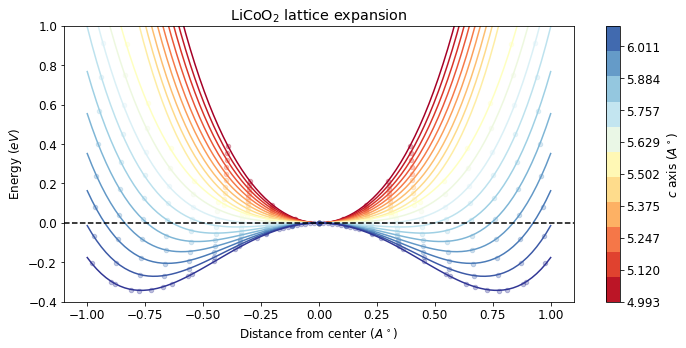

In [38]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.rcParams.update({"font.size": 12})
params = []
c = []
minimum = []
n = len(df.c.unique())
ax = plt.axes()
ax.set_prop_cycle("color", [plt.cm.RdYlBu(i) for i in np.linspace(0, 1, n)])
for key, grp in df.groupby(["c"]):
    y = grp["energy"].values
    # y=(y-y.min())*13.605698065
    y = (y - y[0]) * 13.605698065
    x = grp["distance"].values
    x = x.max() - x
    x = np.concatenate([-1 * x[::-1], x])
    y = np.concatenate([y[::-1], y])
    xdata = np.linspace(-1, 1, 100)
    popt, pcov = curve_fit(phase, x, y)
    params.append(popt)
    c.append(key)
    minimum.append(x[y.argmin()])
    # plt.scatter(x[y.argmin()],y[y.argmin()],c="k",s=30)
    ax.scatter(x, y, s=20, marker="o", alpha=0.3)
    ax.plot(xdata, phase(xdata, *popt), label=np.round(key, 2))
    # ax = grp.plot(ax=ax, kind='line', x='distance', y='energy', label=key)


params = np.array(params)
ax.axhline(0, c="k", ls="--")
ax.set_xlabel("Distance from center ($A^\\circ$)")
ax.set_ylabel("Energy ($eV$)")
ax.set_ylim(-0.4, 1)
# plt.legend()

import matplotlib as mpl
norm = mpl.colors.Normalize(vmin=min(c),vmax=max(c))
sm = plt.cm.ScalarMappable(cmap="RdYlBu", norm=norm)
sm.set_array([])
plt.colorbar(sm, ticks=np.linspace(min(c),max(c),10), 
             boundaries=np.arange(min(c),max(c),.1),label="$c$ axis ($A^\\circ$)")

ax.set_title("LiCoO$_2$ lattice expansion")
plt.tight_layout()
plt.savefig("figures/LiCoO2_lattice.png",dpi=400)
plt.show()


In [79]:
(1-( 14.14562/3)/5.64)*100

16.397044917257688

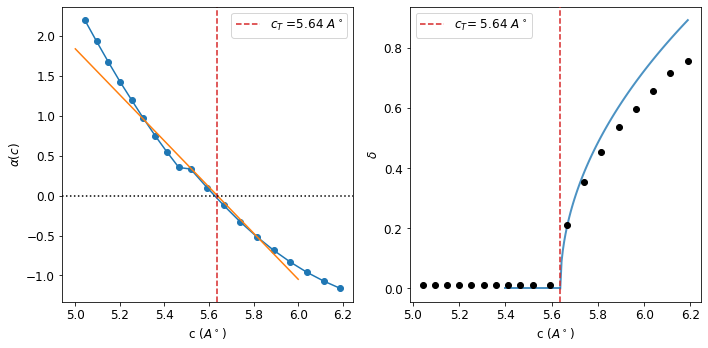

In [78]:
fig, ax1 = plt.subplots(1, 2, figsize=(10,5))
c=[]
for key, grp in df.groupby(["c"]):c.append(key)
c=np.array(c)+.05

plt.rcParams.update({"font.size": 12})
xdata = np.linspace(5.0, 6, 100)
start = 3
popt, pcov = curve_fit(
    straight, c[start:-start], params.T[0][start:-start], p0=[5.3, 1.3]
)
a0 = popt[0]
ct = popt[1]
ax = ax1[0]
ax.plot(c, params.T[0], marker="o")
ax.plot(xdata, straight(xdata, *popt))
ax.axvline(
    popt[1],
    ls="--",
    c="tab:red",
    label=r"$c_T$ ={} $A^\circ$".format(np.round(popt[1], 2)),
)
ax.axhline(0, ls=":", c="k")
ax.set_xlabel(r"c $(A^\circ)$")
ax.set_ylabel(r"$\alpha(c)$")
ax.legend()
start, end = ax.get_xlim()
# percent = np.round((1 - 4.99271 / np.linspace(start, end, 5)) * 100, 2)
# addsecond(ax, percent)


ax = ax1[1]
xdata = np.linspace(-1, 1, 100)
minimum = []
for i in params:
    y = phase(xdata, *i)
    minimum.append(xdata[y.argmin()])
    # plt.plot(xdata,y)
    # plt.scatter(np.abs(xdata[y.argmin()]),y[y.argmin()])
n = 100
ax.plot(np.linspace(5.4, ct, n), np.zeros(n), c="tab:blue", lw=2, alpha=0.8)
ax.plot(
    np.linspace(ct, c[-1], n),
    np.sqrt(a0 * (ct - np.linspace(ct, c[-1], n)) / 2),
    lw=2,
    c="tab:blue",
    alpha=0.8,
)
ax.scatter(c, np.abs(minimum), c="k", zorder=10)
ax.set_ylabel(r"$\delta$")
ax.set_xlabel(r"c $(A^\circ)$")
ax.axvline(
    popt[1],
    ls="--",
    c="tab:red",
    label=r"$c_T$= {} $A^\circ$".format(np.round(popt[1], 2)),
    zorder=9,
)
ax.legend()
start, end = ax.get_xlim()
# percent = np.round((1 - 4.99271 / np.linspace(start, end, 8)) * 100, 2)
# # percent=np.round(np.linspace(start,end,5)-4.99271,2)
# addsecond(ax, percent)


plt.tight_layout()
plt.show()


# NaCoO$_2$

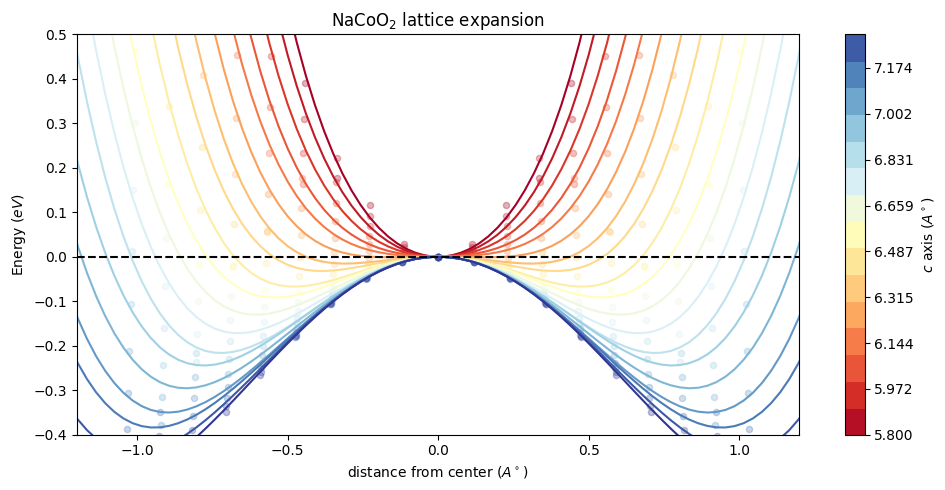

In [6]:
from scipy.optimize import curve_fit


def phase(x, a, b):
    return a * x ** 2 + b * x ** 4


structure_data_fname = "nacoo2/structures_done.txt"
with open(structure_data_fname) as f:
    my_list = [json.loads(line) for line in f]
done_structures = [Structure.from_dict(i) for i in my_list]


class my_structures:
    def __init__(self, structure, energy):
        self.structure = structure
        self.energy = energy
        self.c = structure.lattice.c
        self.distance = structure.get_distance(0, 1)


done_structures = []
for i in my_list:
    struc = Structure.from_dict(i)
    energy = i["energy"]
    done_structures.append(my_structures(struc, energy))

distances = np.array([i.distance for i in done_structures])
energy = np.array([i.energy for i in done_structures])
c = np.array([i.c for i in done_structures])
import pandas as pd

data = {"c": c, "distance": distances, "energy": energy}
df = pd.DataFrame(data)


fig, ax = plt.subplots(figsize=(10, 5))
plt.style.use("default")
params = []
c = []
minimum = []
n = len(df.c.unique())
ax = plt.axes()
ax.set_prop_cycle("color", [plt.cm.RdYlBu(i) for i in np.linspace(0, 1, n)])
for key, grp in df.groupby(["c"]):
    y = grp["energy"].values
    # y=(y-y.min())*13.605698065
    y = (y - y[0]) * 13.605698065
    x = grp["distance"].values
    x = x.max() - x
    x = np.concatenate([-1 * x[::-1], x])
    y = np.concatenate([y[::-1], y])
    xdata = np.linspace(-1.5, 1.5, 100)
    popt, pcov = curve_fit(phase, x, y)
    params.append(popt)
    c.append(key)
    minimum.append(x[y.argmin()])
    # plt.scatter(x[y.argmin()],y[y.argmin()],c="k",s=30)
    ax.scatter(x, y, s=20, marker="o", alpha=0.3)
    ax.plot(xdata, phase(xdata, *popt), label=np.round(key, 2))
    # ax = grp.plot(ax=ax, kind='line', x='distance', y='energy', label=key)


params = np.array(params)
ax.axhline(0, c="k", ls="--")
ax.set_xlabel("distance from center ($A^\\circ$)")
ax.set_ylabel("Energy ($eV$)")
ax.set_ylim(-0.4, 0.5)
ax.set_xlim(-1.2, 1.2)

import matplotlib as mpl
norm = mpl.colors.Normalize(vmin=min(c),vmax=max(c))
sm = plt.cm.ScalarMappable(cmap="RdYlBu", norm=norm)
sm.set_array([])
plt.colorbar(sm, ticks=np.linspace(min(c),max(c),10), 
             boundaries=np.arange(min(c),max(c),.1),label="$c$ axis ($A^\\circ$)")

ax.set_title("NaCoO$_2$ lattice expansion")
plt.tight_layout()
plt.savefig("figures/NaCoO2_lattice.png",dpi=400)
plt.show()


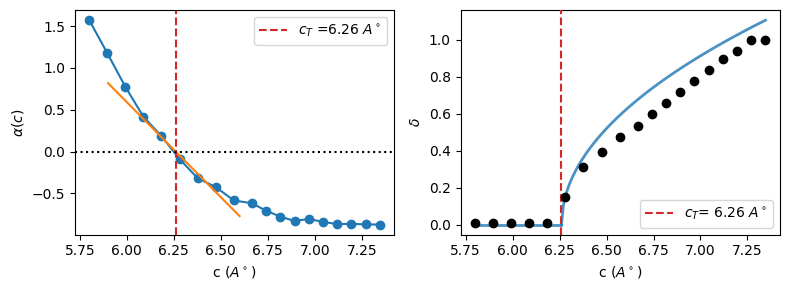

In [14]:
fig, ax1 = plt.subplots(1, 2, figsize=(8, 3))
xdata = np.linspace(5.9, 6.6, 100)
popt, pcov = curve_fit(straight, c[3:8], params.T[0][3:8])
a0 = popt[0]
ct = popt[1]
ax = ax1[0]
ax.plot(c, params.T[0], marker="o")
ax.plot(xdata, straight(xdata, *popt))
ax.axvline(
    popt[1],
    ls="--",
    c="tab:red",
    label=r"$c_T$ ={} $A^\circ$".format(np.round(popt[1], 2)),
)
ax.axhline(0, ls=":", c="k")
ax.set_xlabel(r"c $(A^\circ)$")
ax.set_ylabel(r"$\alpha(c)$")
ax.legend()
# start, end = ax.get_xlim()
# percent = np.round((1 - 5.51386 / np.linspace(start, end, 5)) * 100, 2)
# addsecond(ax, percent)


ax = ax1[1]
xdata = np.linspace(-1, 1, 100)
minimum = []
for i in params:
    y = phase(xdata, *i)
    minimum.append(xdata[y.argmin()])
    # plt.plot(xdata,y)
    # plt.scatter(np.abs(xdata[y.argmin()]),y[y.argmin()])
n = 100
ax.plot(np.linspace(5.8, ct, n), np.zeros(n), c="tab:blue", lw=2, alpha=0.8)
ax.plot(
    np.linspace(ct, c[-1], n),
    np.sqrt(a0 * (ct - np.linspace(ct, c[-1], n)) / params.T[1].mean() * 0.65),
    lw=2,
    c="tab:blue",
    alpha=0.8,
)
ax.scatter(c, np.abs(minimum), c="k", zorder=10)
ax.set_ylabel(r"$\delta$")
ax.set_xlabel(r"c $(A^\circ)$")
ax.axvline(
    popt[1],
    ls="--",
    c="tab:red",
    label=r"$c_T$= {} $A^\circ$".format(np.round(popt[1], 2)),
    zorder=9,
)
ax.legend()

start, end = ax.get_xlim()
# percent=np.round((1-5.51386/np.linspace(start,end,8))*100,2)
# percent=np.round(np.linspace(start,end,8)-5.51386,2)
# percent = np.round(np.linspace(start, end, 8) * 3, 2)
# addsecond(ax, percent)

plt.tight_layout()
plt.show()


In [85]:
(1- (15.74/3)/6.26) *100

16.1874334398296

## Charge analysis

In [27]:
import pickle

def get_data(fname,return_pickle=0):
    licoo2=pickle.load(open( fname, "rb" ))
    energy=[i.energy for i in licoo2]
    licharge=[i.structure[1].charge for i in licoo2]
    cocharge=[i.structure[0].charge for i in licoo2]
    o1charge=[i.structure[2].charge for i in licoo2]
    o2charge=[i.structure[3].charge for i in licoo2]
    smoothcharge=[i.structure.charge for i in licoo2]
    distance=[i.structure.get_distance(0,1) for i in licoo2]
    c=[i.structure.lattice.c for i in licoo2]
    data = {"c": c, "distance": distance, "energy": energy, "li":licharge,"co":cocharge,"o1":o1charge,"o2":o2charge,"smooth":smoothcharge}
    df = pd.DataFrame(data)
    df["li"][df["li"]<0.0]=0
    if return_pickle:return df,licoo2
    else:return df

# LiCoO$_2$

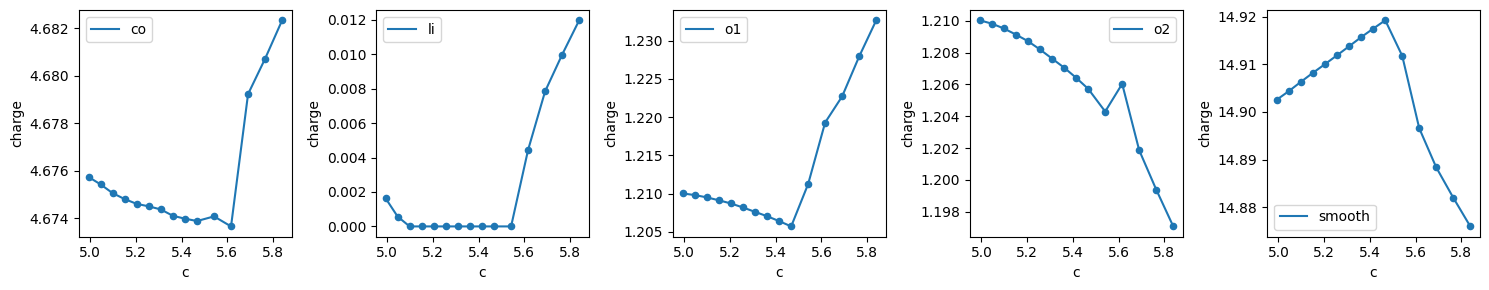

In [28]:
df=get_data("licoo2/data")
plots=["co","li","o1","o2","smooth"]
fig,ax=plt.subplots(1,len(plots),figsize=(15,3))
for j,i in enumerate(plots):
    df.sort_values("energy").groupby('c', as_index=False).first()[:-4].plot.scatter(x="c",y=i,ax=ax[j])
    df.sort_values("energy").groupby('c', as_index=False).first()[:-4].plot(x="c",y=i,ax=ax[j])
    ax[j].set_ylabel("charge")
plt.tight_layout()

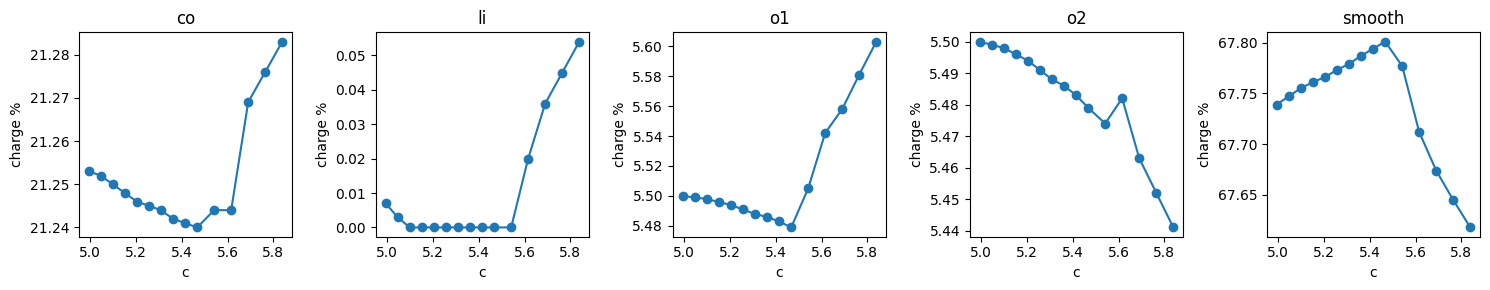

In [22]:
df1=df.sort_values("energy").groupby('c', as_index=False).first()[:-4][plots]
cx=df.sort_values("energy").groupby('c', as_index=False).first()[:-4].c.values
df1=df1.div(df1.sum(axis=1), axis=0).mul(100).round(3)
fig,ax=plt.subplots(1,len(plots),figsize=(15,3))
for j,i in enumerate(plots):
    ax[j].scatter(cx,df1[i])
    ax[j].plot(cx,df1[i])
    ax[j].set_title(i)
    ax[j].set_ylabel("charge %")
    ax[j].set_xlabel("c")
plt.tight_layout()

# NaCoO$_2$

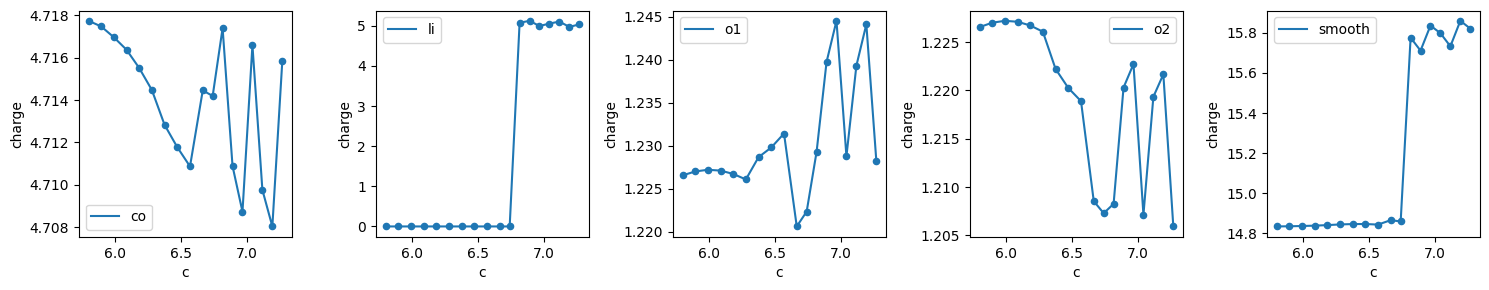

In [24]:
df=get_data("nacoo2/data")
plots=["co","li","o1","o2","smooth"]
fig,ax=plt.subplots(1,len(plots),figsize=(15,3))
for j,i in enumerate(plots):
    df.sort_values("energy").groupby('c', as_index=False).first()[:-1].plot.scatter(x="c",y=i,ax=ax[j])
    df.sort_values("energy").groupby('c', as_index=False).first()[:-1].plot(x="c",y=i,ax=ax[j])
    ax[j].set_ylabel("charge")
plt.tight_layout()

## Bader analysis

Not working out. Need to look at bader analysis. So lets grab these structures that have the lowest energy and do GPAW to get the bader analysis !

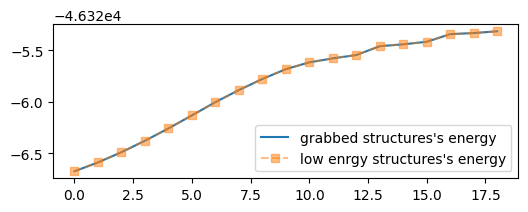

In [38]:
###---- for Licoo2
df,licoo2=get_data("licoo2/data",return_pickle=True)
needed_energy=df.sort_values("energy").groupby('c', as_index=False).first().energy.values
structures=[i for i in licoo2 if (i.energy in needed_energy) ]
structures=sorted(structures, key=lambda k: k.energy) 
pickle.dump(structures, open("licoo2/min_structures_licoo2", "wb"))

#----- for Nacoo2
df,licoo2=get_data("nacoo2/data",return_pickle=True)
needed_energy=df.sort_values("energy").groupby('c', as_index=False).first().energy.values
structures=[i for i in licoo2 if (i.energy in needed_energy) ]
structures=sorted(structures, key=lambda k: k.energy) 
pickle.dump(structures, open("nacoo2/min_structures_nacoo2", "wb"))


#---check if they are same
fig,ax=plt.subplots(figsize=(6,2))
ax.plot([i.energy for i in structures],label="grabbed structures's energy")
ax.plot(needed_energy,marker="s",label="low enrgy structures's energy",ls="--",alpha=0.5)
plt.legend()
plt.show()

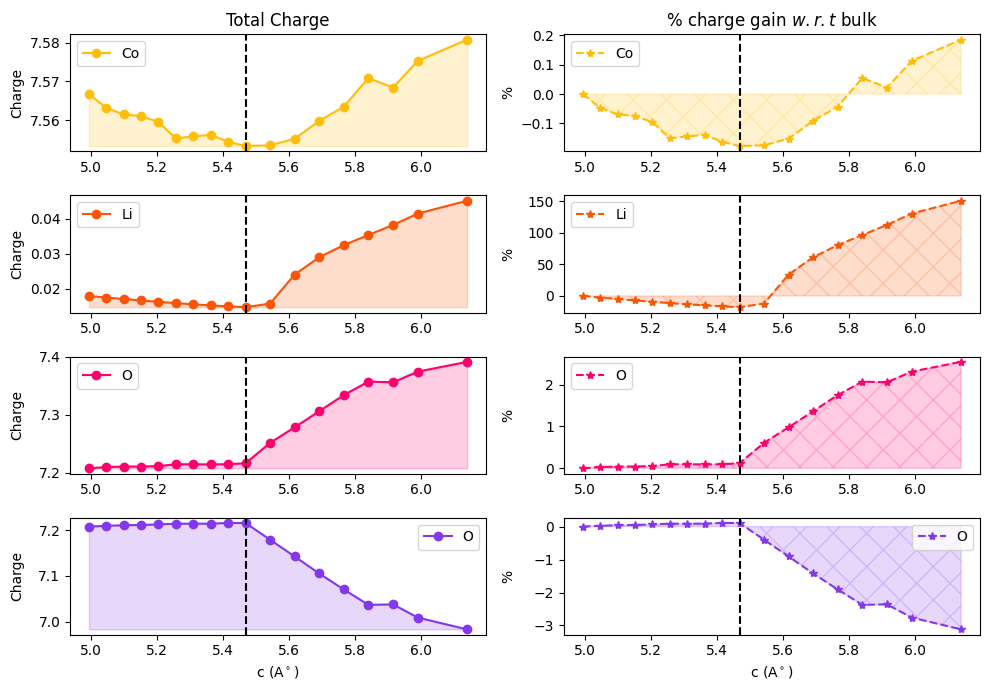

In [51]:
structures=pickle.load(open("licoo2/charge_data", "rb"))
fig,ax1=plt.subplots(len(structures[0]),2,figsize=(10,7))
n=0
structures.remove(structures[-2])
colors=["#ffbe0b","#fb5607","#ff006e","#8338ec"]
charges=[]
ax=ax1[:,0]
ax[0].set_title("Total Charge")
ax[-1].set_xlabel("c (A$^\circ$)")
for j in range(len(structures[0])):
    mul=0
    if j==1:
        mul=np.concatenate(([0]*9,np.linspace(0,.02,9)))
    if j==2:
        mul=-1*np.concatenate(([0]*9,np.linspace(0,.02,9)))
    charge=np.array([i[j].charge for i in structures])+mul
    charges.append(charge)
    c=[i.lattice.c for i in structures]
    ax[j].plot(c,charge,marker="o",label= structures[0][j].species_string,color=colors[j])
    ax[j].fill_between(c,charge,charge.min(),color=colors[j],alpha=0.2)
    ax[j].axvline(c[9],c="k",ls="--")
    ax[j].legend()
    ax[j].set_ylabel("Charge")
charges=np.array(charges)
percent=[(charges[i]-charges[i][0])*100/charges[i][0] for i in range(charges.shape[0])]
percent=np.array(percent)
ax=ax1[:,1]
ax[0].set_title("% charge gain $w.r.t$ bulk")
ax[-1].set_xlabel("c (A$^\circ$)")
colors=["#ffbe0b","#fb5607","#ff006e","#8338ec"]
for j in range(len(structures[0])):
    ax[j].plot(c,percent[j],marker="*",label= structures[0][j].species_string,color=colors[j],ls="--")
    ax[j].fill_between(c,percent[j],0,color=colors[j],alpha=0.2,hatch="X")
    ax[j].axvline(c[9],c="k",ls="--")
    ax[j].legend()
    ax[j].set_ylabel("%")
    

plt.tight_layout()
fig.align_labels()
plt.savefig("Charge-LiCoO2.png",dpi=400)
plt.show()